In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

% matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD

from datetime import datetime
from dateutil.relativedelta import relativedelta

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from funcs_var import *

Using TensorFlow backend.


## Data Collection

#### short term interst rate

In [200]:
stir = pd.read_csv('var_ru/ru_stir.csv')

In [201]:
stir = stir[['TIME', 'Value']].copy()

In [202]:
stir['TIME'] = pd.to_datetime(stir['TIME'])

In [203]:
stir.index = stir['TIME']

In [204]:
stir = stir[['Value']].copy()

In [205]:
stir['date'] = stir.index.tolist()

#### inflation rate

In [206]:
infr = pd.read_csv('var_ru/ru_inf.csv')

In [207]:
infr = infr.sort_index(axis=0, ascending=False).reset_index(drop=True)

In [208]:
inf_l = []
for i in range(len(infr.iloc[:, 1:13])):
    inf_l = inf_l + infr.iloc[i, 1:13].tolist()

In [209]:
inf_l = inf_l[:-8]

In [210]:
for i in range(len(inf_l)):
    inf_l[i] = inf_l[i].replace(',', '.')

In [211]:
for i in range(len(inf_l)):
    inf_l[i] = float(inf_l[i])

In [212]:
date_list = []
for i in range(len(inf_l)):
    date_list.append(datetime.strptime('1991-01', '%Y-%M') + relativedelta(months=i))

In [213]:
infr = pd.DataFrame(inf_l, date_list, ['Value']).iloc[:-4, :]

In [214]:
q_list = []
for y in range(1991, 2017):
    for q in ['Q1', 'Q1', 'Q1', 'Q2', 'Q2', 'Q2', 'Q3', 'Q3', 'Q3', 'Q4', 'Q4', 'Q4']:
        q_list.append(str(y)+q)

In [215]:
infr['q'] = q_list

In [216]:
g = infr.groupby('q')['Value']
quarters = pd.unique(infr['q']).tolist()

In [217]:
ir_q = []
for q in quarters:
    l_g = g.get_group(q).tolist()
    l_g_m = [i*0.01 for i in l_g]
    current = 1
    for i in l_g_m:
        current = current + current*i
    ir_q.append((current-1)*100)

In [218]:
infr = pd.DataFrame([ir_q, pd.to_datetime(quarters).tolist()], ['Value', 'date']).T

#### GDP

In [219]:
gdp = pd.read_csv('var_ru/ru_gdp_real.csv')

In [220]:
gdp_l = gdp.T.iloc[1:, 1].tolist()

In [221]:
for i in range(len(gdp_l)):
    gdp_l[i] = str(gdp_l[i])

In [222]:
for i in range(len(gdp_l)):
    gdp_l[i] = gdp_l[i].replace(',', '.')

In [223]:
for i in range(len(gdp_l)):
    gdp_l[i] = float(gdp_l[i])

In [224]:
date_list = []
for i in range(0, len(gdp_l)*3, 3):
    date_list.append(datetime.strptime('1995-01', '%Y-%m') + relativedelta(months=i))

In [225]:
gdp = pd.DataFrame(gdp_l, date_list, ['Value'])

In [226]:
gdp['date'] = gdp.index.tolist()

#### Make full df

In [227]:
gdp.index = gdp['date']
gdp = gdp[['Value']].copy()
stir.index = stir['date']
stir = stir[['Value']].copy()
infr.index = infr['date']
infr = infr[['Value']].copy()

In [228]:
df_var_t = pd.concat([gdp, stir, infr], axis=1).dropna()
df_var_t.columns = ['gdp', 'stir', 'infr']

Results of Dickey-Fuller Test:
Test Statistic                 -1.359580
p-value                         0.601493
#Lags Used                      1.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64


Results of KPSS Test:
Test Statistic            0.669773
p-value                   0.016293
#Lags Used               12.000000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
dtype: float64


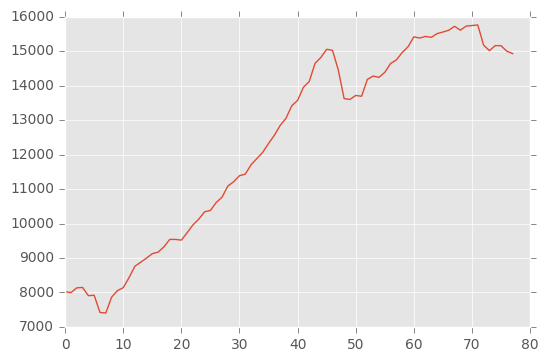

In [229]:
test_stationarity(df_var_t['gdp'])

Results of Dickey-Fuller Test:
Test Statistic                 -1.878809
p-value                         0.342095
#Lags Used                      3.000000
Number of Observations Used    74.000000
Critical Value (1%)            -3.521980
Critical Value (5%)            -2.901470
Critical Value (10%)           -2.588072
dtype: float64


Results of KPSS Test:
Test Statistic            0.375694
p-value                   0.087632
#Lags Used               12.000000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
dtype: float64


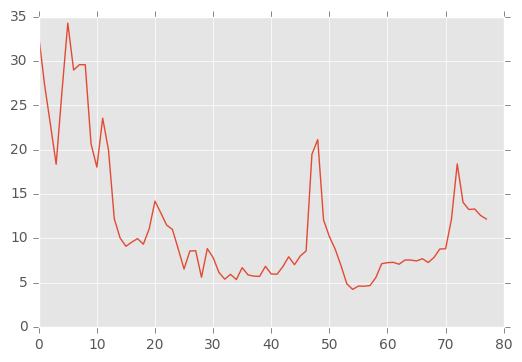

In [230]:
test_stationarity(df_var_t['stir'])

Results of Dickey-Fuller Test:
Test Statistic                 -3.573402
p-value                         0.006290
#Lags Used                     12.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


Results of KPSS Test:
Test Statistic            0.412117
p-value                   0.071932
#Lags Used               12.000000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
dtype: float64


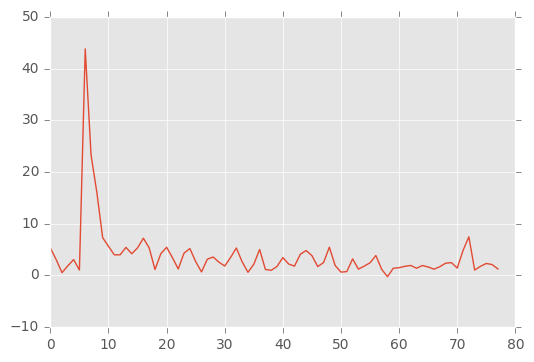

In [231]:
test_stationarity(df_var_t['infr'])

Рвзности

Results of Dickey-Fuller Test:
Test Statistic                 -5.575741
p-value                         0.000001
#Lags Used                      0.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64


Results of KPSS Test:
Test Statistic            0.235576
p-value                   0.100000
#Lags Used               12.000000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


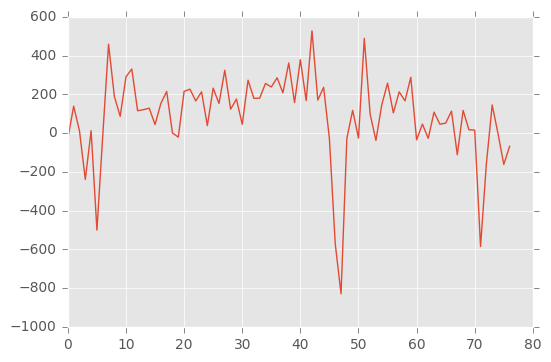

In [232]:
test_stationarity(diff_series(df_var_t['gdp']))

Results of Dickey-Fuller Test:
Test Statistic                -8.596966e+00
p-value                        7.034930e-14
#Lags Used                     1.000000e+00
Number of Observations Used    7.500000e+01
Critical Value (1%)           -3.520713e+00
Critical Value (5%)           -2.900925e+00
Critical Value (10%)          -2.587781e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.398520
p-value                   0.077793
#Lags Used               12.000000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Critical Value (5%)       0.463000
Critical Value (10%)      0.347000
dtype: float64


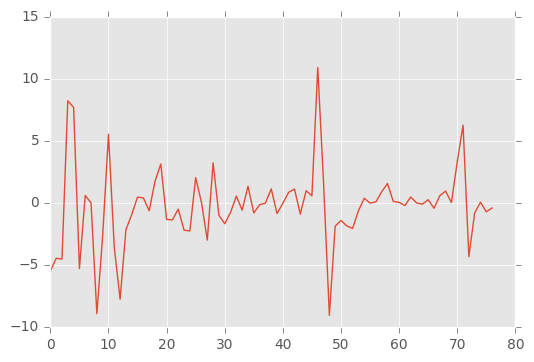

In [233]:
test_stationarity(diff_series(df_var_t['stir']))

Results of Dickey-Fuller Test:
Test Statistic                -7.011675e+00
p-value                        6.896144e-10
#Lags Used                     2.000000e+00
Number of Observations Used    7.400000e+01
Critical Value (1%)           -3.521980e+00
Critical Value (5%)           -2.901470e+00
Critical Value (10%)          -2.588072e+00
dtype: float64


Results of KPSS Test:
Test Statistic            0.08435
p-value                   0.10000
#Lags Used               12.00000
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
Critical Value (5%)       0.46300
Critical Value (10%)      0.34700
dtype: float64


/home/andrey/anaconda3/envs/neural_net/lib/python3.5/site-packages/statsmodels/tsa/stattools.py:1260: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


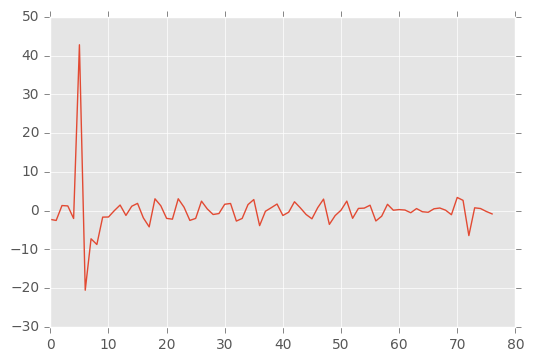

In [234]:
test_stationarity(diff_series(df_var_t['infr']))

In [235]:
df_var_t_diff = diff_series(df_var_t)

## Forecasting

In [236]:
STEPS = 6
LAG = 2

In [237]:
train = df_var_t_diff.iloc[:-STEPS, :]
test = df_var_t_diff.iloc[-STEPS:, :]

train_real = df_var_t.iloc[:-STEPS, :]
test_real = df_var_t.iloc[-STEPS:, :]

### VAR

In [238]:
def var_model(train, steps, lags, years=None, period='m'):
    df = np.array(train)
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model = VAR(df)
    fitm = model.fit(maxlags=lags)
    var_in = pd.DataFrame(fitm.fittedvalues, 
                          columns=train.columns, 
                          index=years)
    var_out = fitm.forecast(y=df, steps=steps)
    var_out = pd.DataFrame(var_out, 
                           columns=train.columns, 
                           index=years_out)
    return {'in':var_in, 'out':var_out}

In [290]:
var_result = var_model(train, steps=STEPS, lags=LAG, years=train.index[LAG:], period='q')
print(error(var_result['out']['stir'], test['stir']))
print(error(var_result['out']['infr'], test['infr']))
print(error(var_result['out']['gdp'], test['gdp']))

{'mae': 1.6583329178706716, 'mse': 7.5574228108908619, 'rmse': 2.7490767197171602}
{'mae': 2.1736040415197122, 'mse': 10.149413745713352, 'rmse': 3.185814455631927}
{'mae': 238.96874430396664, 'mse': 89630.757305378691, 'rmse': 299.38396300633519}


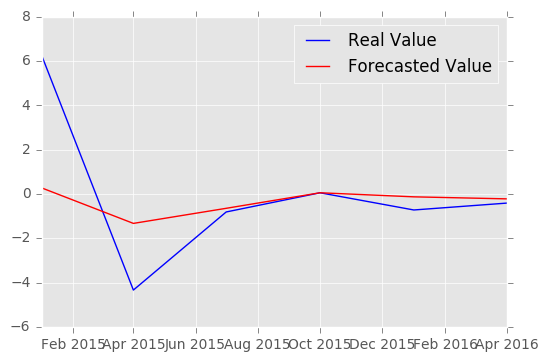

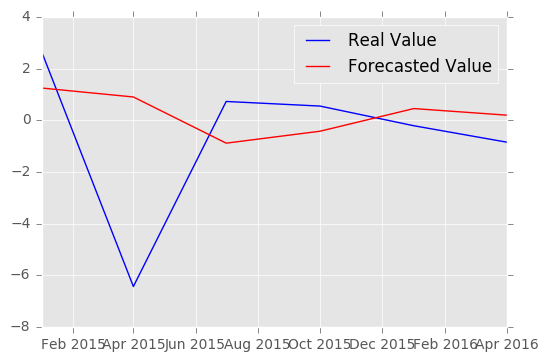

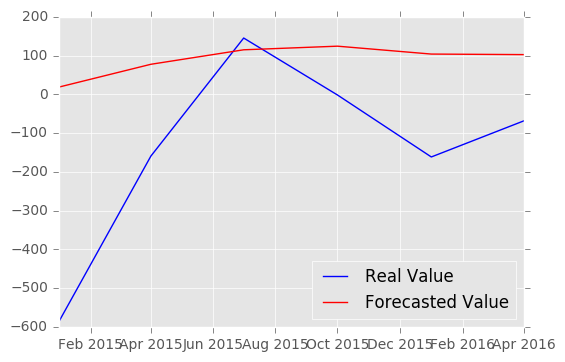

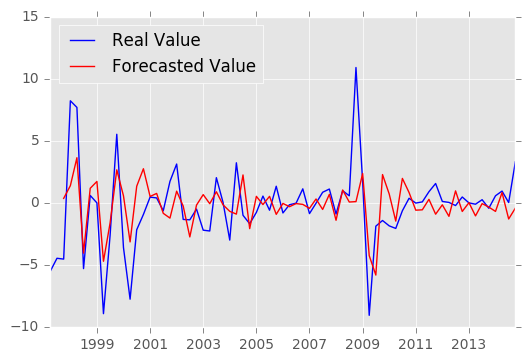

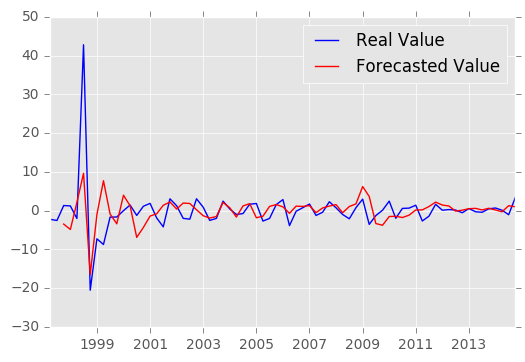

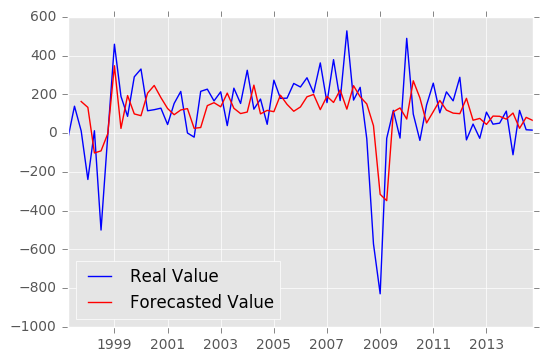

In [240]:
plot_compar(var_result['out']['stir'], test['stir'])
plot_compar(var_result['out']['infr'], test['infr'])
plot_compar(var_result['out']['gdp'], test['gdp'])
plot_compar(var_result['in']['stir'], train['stir'])
plot_compar(var_result['in']['infr'], train['infr'])
plot_compar(var_result['in']['gdp'], train['gdp'])

{'mae': 3.1401458592999028, 'mse': 11.600511034399119, 'rmse': 3.4059522947920335}
{'mae': 4.0084472872989751, 'mse': 18.080907815941433, 'rmse': 4.2521650739289782}
{'mae': 961.47013754347029, 'mse': 989888.75593772915, 'rmse': 994.93153329147685}


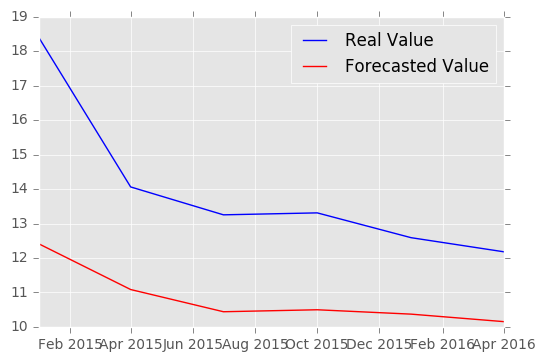

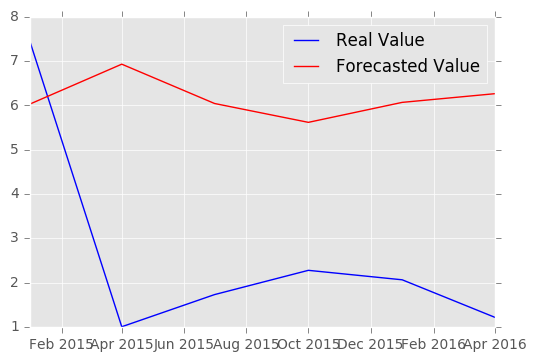

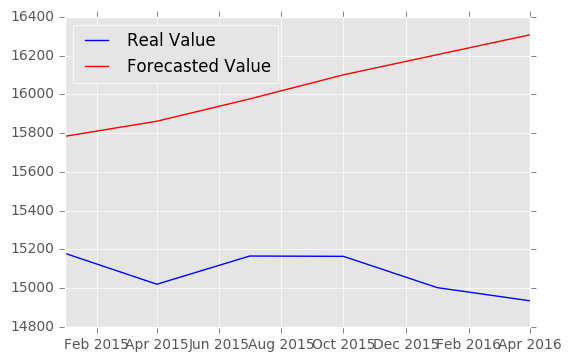

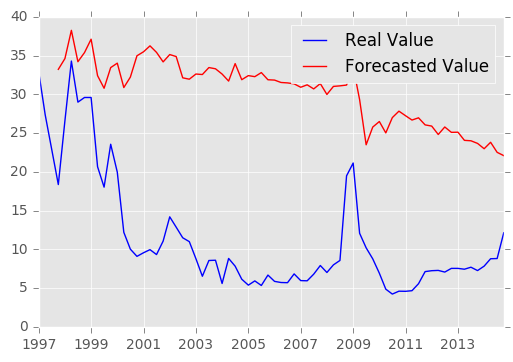

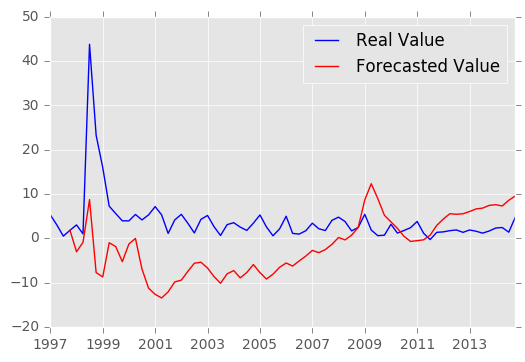

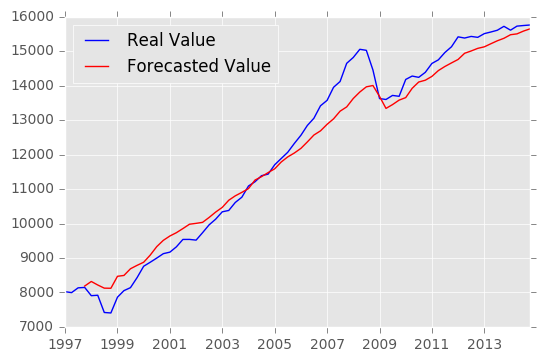

In [241]:
var_undiff_out = undiff(previous_df=train_real, diff_df=var_result['out'])
var_undiff_in = undiff(previous_df=train_real.head(1), diff_df=var_result['in'])
print(error(var_undiff_out['stir'], test_real['stir']))
print(error(var_undiff_out['infr'], test_real['infr']))
print(error(var_undiff_out['gdp'], test_real['gdp']))
plot_compar(var_undiff_out['stir'], test_real['stir'])
plot_compar(var_undiff_out['infr'], test_real['infr'])
plot_compar(var_undiff_out['gdp'], test_real['gdp'])
plot_compar(var_undiff_in['stir'], train_real['stir'])
plot_compar(var_undiff_in['infr'], train_real['infr'])
plot_compar(var_undiff_in['gdp'], train_real['gdp'])

## ANN

In [242]:
df_nn = nn_transform(train, n=LAG)
df_nn_s, m, s = scaler(df_nn)
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [243]:
def nn_model(x, y, n_feat, lag, steps, model, years=None, epoch=100, period='q'):
    years_out=None
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years is not None:
        years = pd.to_datetime(years)
        years_out = [pd.to_datetime(years[len(years)-1]) + relativedelta(months=i) for i in range(b, p+1, s)]
    model.fit(np.array(x), np.array(y),
       nb_epoch=epoch, 
       verbose=2,
       batch_size=1)
    nn_in = pd.DataFrame(model.predict(np.array(x)), 
                         columns=y.columns, 
                         index=years)
    nn_out = nn_predict(model, train, lags=lag, steps=steps)
    if years is not None:
        nn_out.index = years_out
    return {'in':nn_in, 'out':nn_out}

Первый запуск

In [246]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [247]:
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=500)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/500
0s - loss: 1.0485
Epoch 2/500
0s - loss: 0.9977
Epoch 3/500
0s - loss: 0.9861
Epoch 4/500
0s - loss: 0.9752
Epoch 5/500
0s - loss: 0.9739
Epoch 6/500
0s - loss: 0.9687
Epoch 7/500
0s - loss: 0.9678
Epoch 8/500
0s - loss: 0.9634
Epoch 9/500
0s - loss: 0.9598
Epoch 10/500
0s - loss: 0.9583
Epoch 11/500
0s - loss: 0.9565
Epoch 12/500
0s - loss: 0.9550
Epoch 13/500
0s - loss: 0.9507
Epoch 14/500
0s - loss: 0.9512
Epoch 15/500
0s - loss: 0.9457
Epoch 16/500
0s - loss: 0.9418
Epoch 17/500
0s - loss: 0.9413
Epoch 18/500
0s - loss: 0.9383
Epoch 19/500
0s - loss: 0.9354
Epoch 20/500
0s - loss: 0.9349
Epoch 21/500
0s - loss: 0.9299
Epoch 22/500
0s - loss: 0.9274
Epoch 23/500
0s - loss: 0.9243
Epoch 24/500
0s - loss: 0.9224
Epoch 25/500
0s - loss: 0.9168
Epoch 26/500
0s - loss: 0.9162
Epoch 27/500
0s - loss: 0.9137
Epoch 28/500
0s - loss: 0.9101
Epoch 29/500
0s - loss: 0.9059
Epoch 30/500
0s - loss: 0.9033
Epoch 31/500
0s - loss: 0.9013
Epoch 32/500
0s - loss: 0.8987
Epoch 33/500
0s -

{'mae': 3.256389760378529, 'mse': 29.80176111194395, 'rmse': 5.4590989285727316}
{'mae': 7.3857867515540496, 'mse': 133.78898874618952, 'rmse': 11.566719013885896}
{'mae': 199.22058908422756, 'mse': 44788.004327045819, 'rmse': 211.63176587423217}


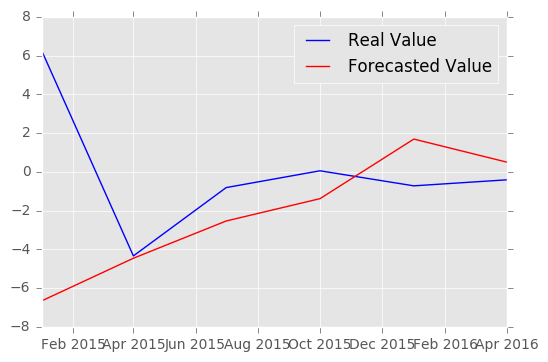

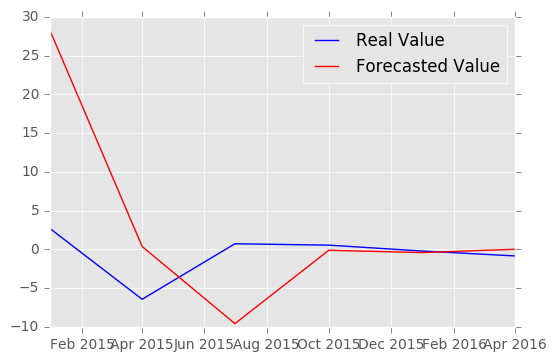

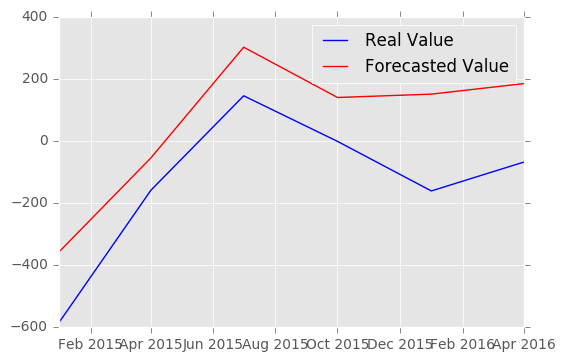

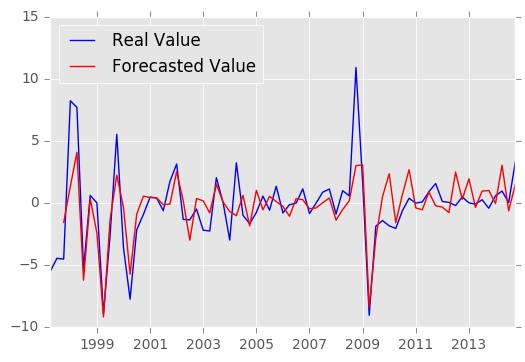

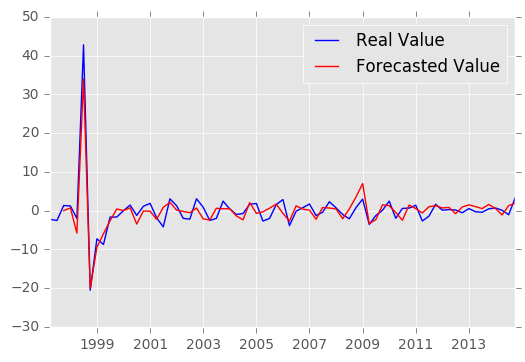

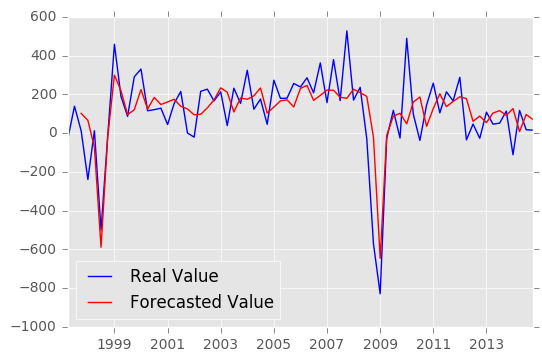

In [248]:
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'mae': 13.937711279881007, 'mse': 195.72810840673495, 'rmse': 13.990286216040577}
{'mae': 24.027071885551209, 'mse': 593.03851466082335, 'rmse': 24.352382114709503}
{'mae': 635.88871580137493, 'mse': 519034.71906519431, 'rmse': 720.44064229136484}


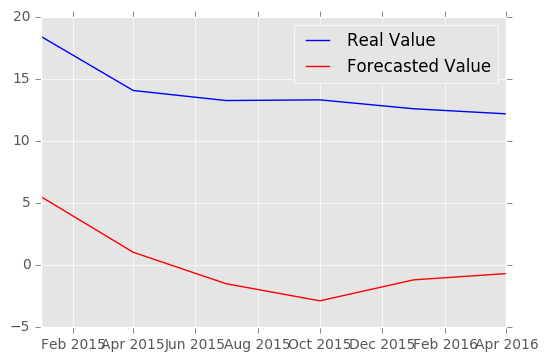

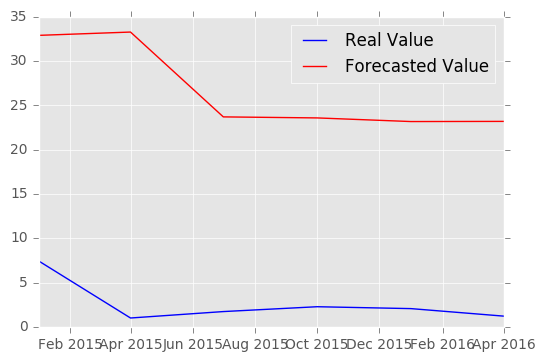

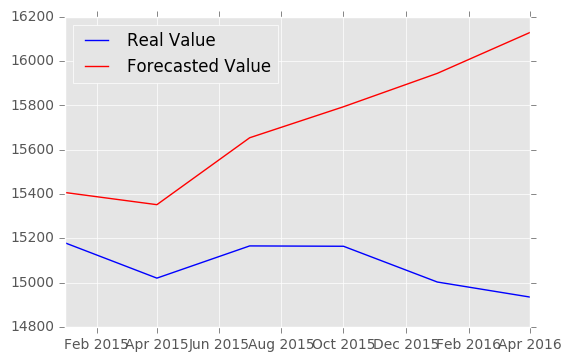

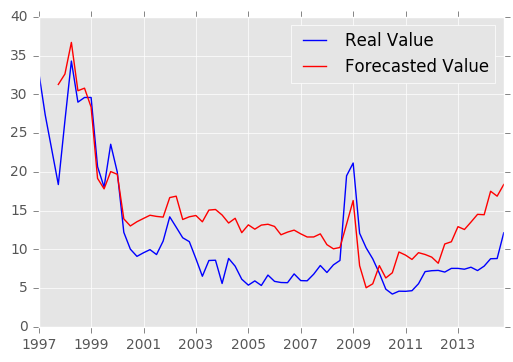

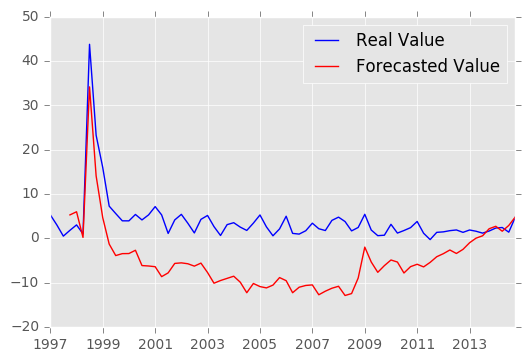

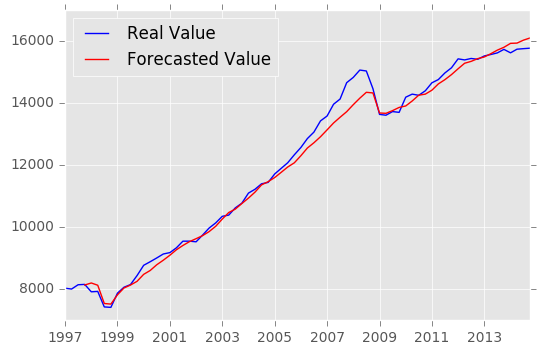

In [249]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

Второй запуск

In [250]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 1.1032
Epoch 2/600
0s - loss: 1.0158
Epoch 3/600
0s - loss: 0.9831
Epoch 4/600
0s - loss: 0.9722
Epoch 5/600
0s - loss: 0.9680
Epoch 6/600
0s - loss: 0.9668
Epoch 7/600
0s - loss: 0.9599
Epoch 8/600
0s - loss: 0.9568
Epoch 9/600
0s - loss: 0.9543
Epoch 10/600
0s - loss: 0.9504
Epoch 11/600
0s - loss: 0.9486
Epoch 12/600
0s - loss: 0.9421
Epoch 13/600
0s - loss: 0.9407
Epoch 14/600
0s - loss: 0.9354
Epoch 15/600
0s - loss: 0.9329
Epoch 16/600
0s - loss: 0.9359
Epoch 17/600
0s - loss: 0.9239
Epoch 18/600
0s - loss: 0.9222
Epoch 19/600
0s - loss: 0.9208
Epoch 20/600
0s - loss: 0.9135
Epoch 21/600
0s - loss: 0.9109
Epoch 22/600
0s - loss: 0.9104
Epoch 23/600
0s - loss: 0.9032
Epoch 24/600
0s - loss: 0.8988
Epoch 25/600
0s - loss: 0.8959
Epoch 26/600
0s - loss: 0.8924
Epoch 27/600
0s - loss: 0.8897
Epoch 28/600
0s - loss: 0.8856
Epoch 29/600
0s - loss: 0.8818
Epoch 30/600
0s - loss: 0.8773
Epoch 31/600
0s - loss: 0.8745
Epoch 32/600
0s - loss: 0.8721
Epoch 33/600
0s -

{'mae': 2.0188638751205903, 'mse': 12.822529910095684, 'rmse': 3.5808560303502408}
{'mae': 1.6537941151170816, 'mse': 7.0205163034260494, 'rmse': 2.6496256911922575}
{'mae': 331.52504428010116, 'mse': 160445.69247463485, 'rmse': 400.55672816048769}


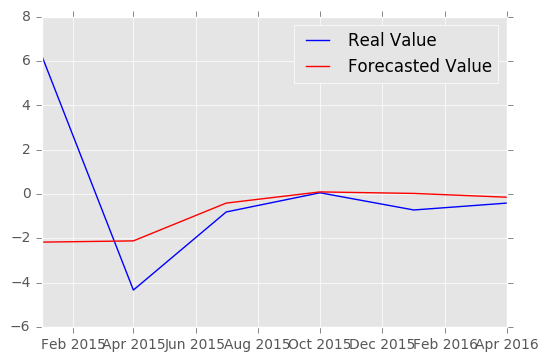

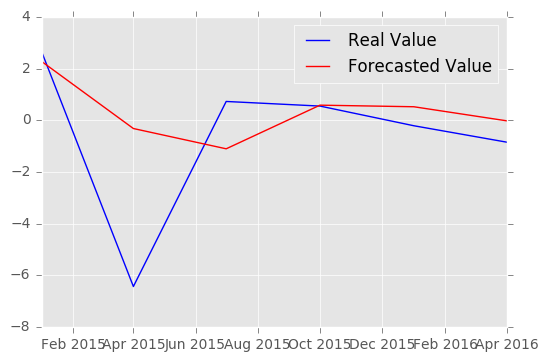

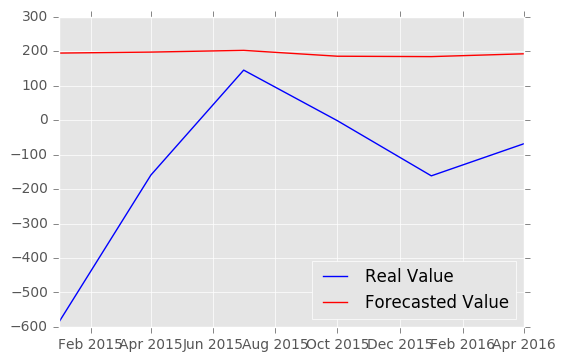

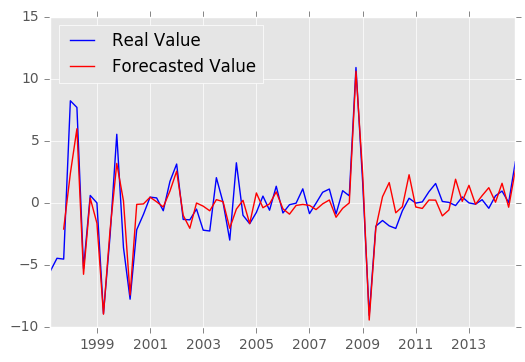

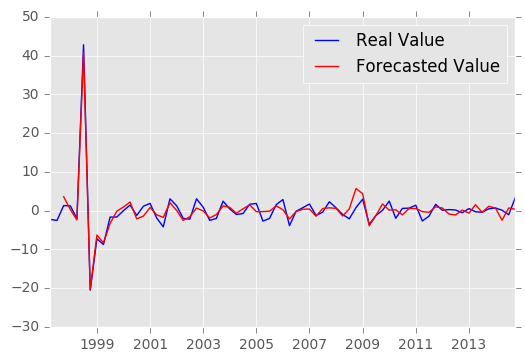

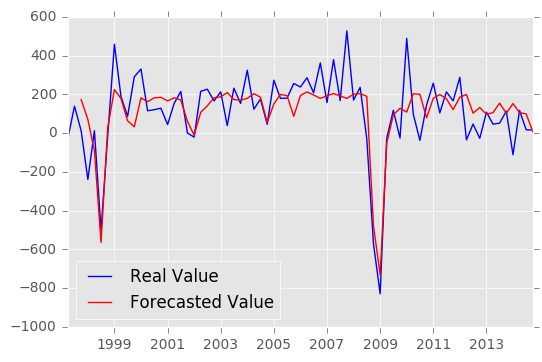

In [251]:
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'mae': 6.0077350932975504, 'mse': 37.516891072964533, 'rmse': 6.1251033520230935}
{'mae': 4.0226619067411509, 'mse': 19.323718121926063, 'rmse': 4.3958751258339976}
{'mae': 1368.6387580868857, 'mse': 2030570.9077780352, 'rmse': 1424.9810201465966}


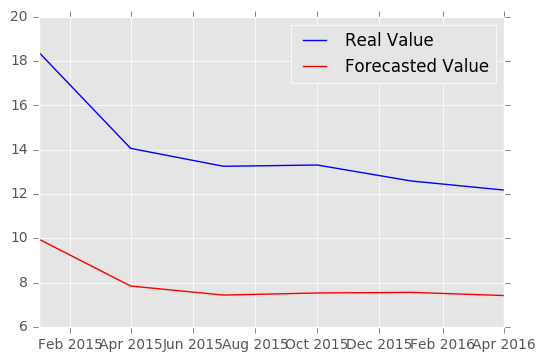

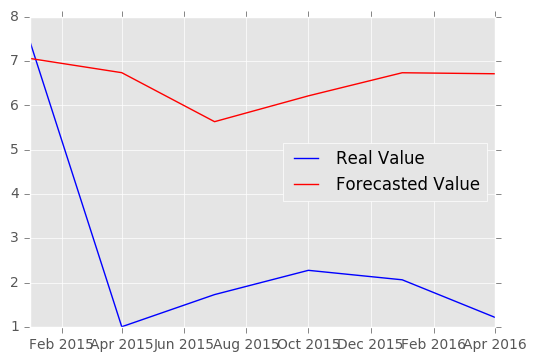

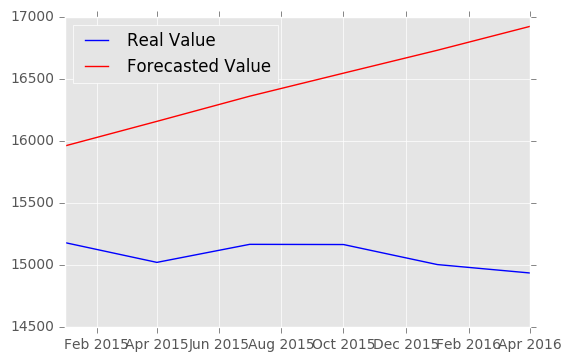

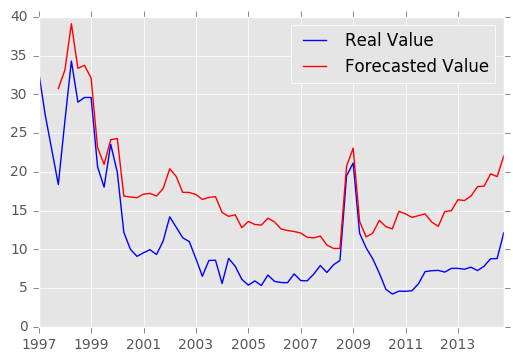

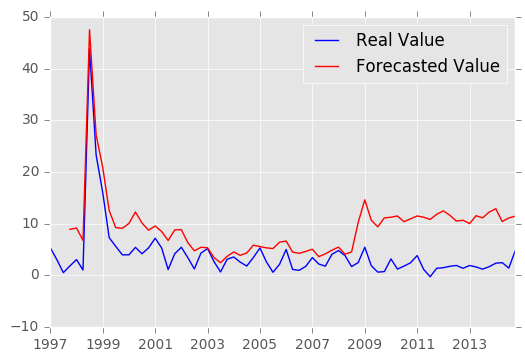

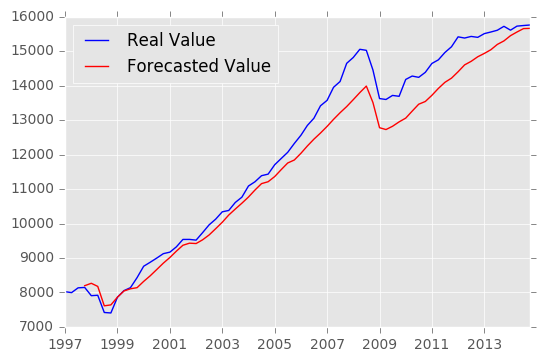

In [252]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

С DropOut

In [253]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.5816
Epoch 2/600
0s - loss: 1.1600
Epoch 3/600
0s - loss: 1.1094
Epoch 4/600
0s - loss: 1.0234
Epoch 5/600
0s - loss: 1.0058
Epoch 6/600
0s - loss: 0.9849
Epoch 7/600
0s - loss: 0.9533
Epoch 8/600
0s - loss: 1.0178
Epoch 9/600
0s - loss: 1.0026
Epoch 10/600
0s - loss: 0.9995
Epoch 11/600
0s - loss: 1.0040
Epoch 12/600
0s - loss: 1.0247
Epoch 13/600
0s - loss: 0.9963
Epoch 14/600
0s - loss: 0.9984
Epoch 15/600
0s - loss: 0.9654
Epoch 16/600
0s - loss: 0.9834
Epoch 17/600
0s - loss: 0.9891
Epoch 18/600
0s - loss: 1.0088
Epoch 19/600
0s - loss: 1.0195
Epoch 20/600
0s - loss: 0.9963
Epoch 21/600
0s - loss: 0.9849
Epoch 22/600
0s - loss: 1.0067
Epoch 23/600
0s - loss: 0.9937
Epoch 24/600
0s - loss: 1.0099
Epoch 25/600
0s - loss: 0.9811
Epoch 26/600
0s - loss: 1.0136
Epoch 27/600
0s - loss: 0.9905
Epoch 28/600
0s - loss: 0.9913
Epoch 29/600
0s - loss: 1.0038
Epoch 30/600
0s - loss: 0.9805
Epoch 31/600
0s - loss: 0.9666
Epoch 32/600
0s - loss: 0.9778
Epoch 33/600
0s -

{'mae': 2.4094134963313389, 'mse': 16.854182072936595, 'rmse': 4.1053845219341625}
{'mae': 1.9095770505974305, 'mse': 6.7866148215378663, 'rmse': 2.6051132070483742}
{'mae': 300.88430698647721, 'mse': 169067.58753893996, 'rmse': 411.17829166790892}


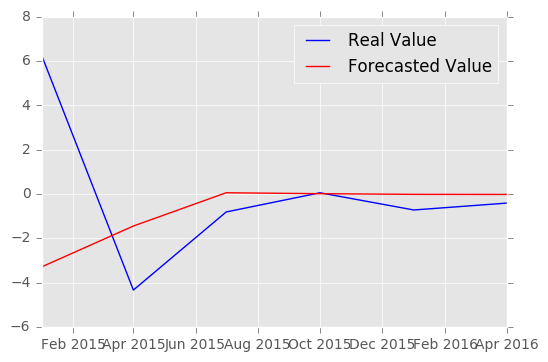

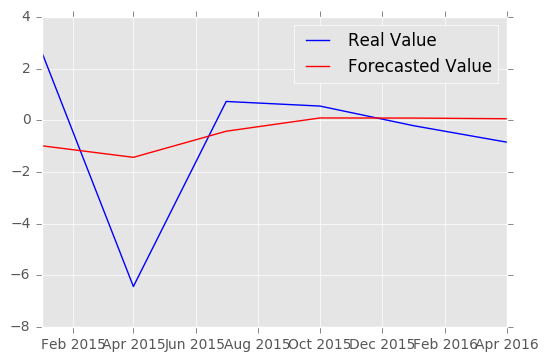

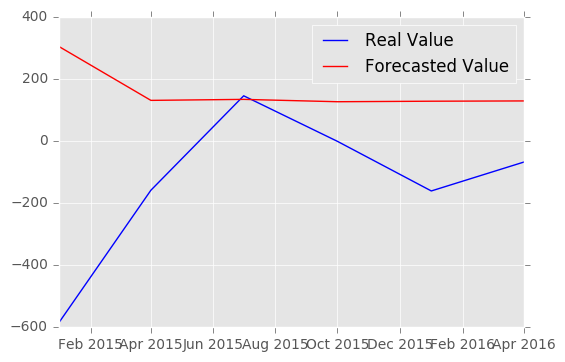

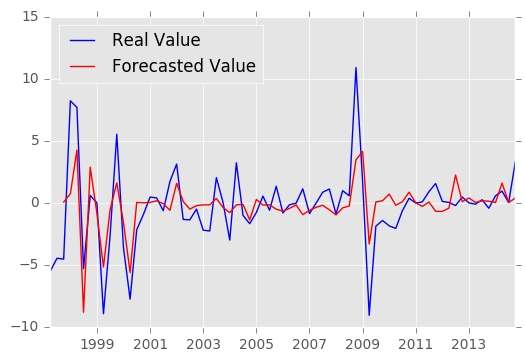

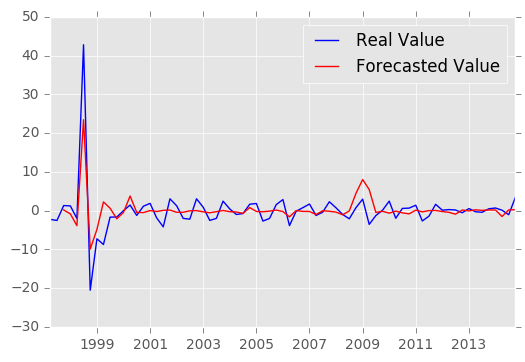

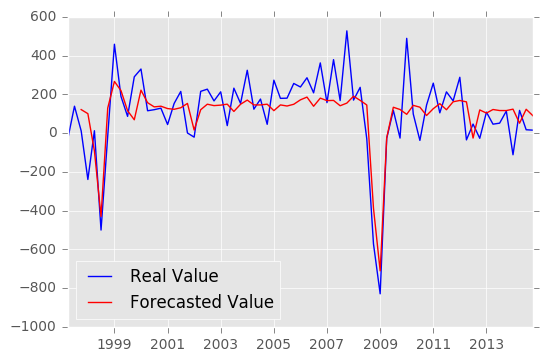

In [254]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test['stir']))
print(error(nn_result_as['out']['infr'], test['infr']))
print(error(nn_result_as['out']['gdp'], test['gdp']))

plot_compar(nn_result_as['out']['stir'], test['stir'])
plot_compar(nn_result_as['out']['infr'], test['infr'])
plot_compar(nn_result_as['out']['gdp'], test['gdp'])
plot_compar(nn_result_as['in']['stir'], train['stir'])
plot_compar(nn_result_as['in']['infr'], train['infr'])
plot_compar(nn_result_as['in']['gdp'], train['gdp'])

{'mae': 6.2890700292060684, 'mse': 42.052845843592486, 'rmse': 6.4848165620619129}
{'mae': 1.0751917452068296, 'mse': 2.6867140803063898, 'rmse': 1.639119910289174}
{'mae': 1316.6932686605148, 'mse': 1819135.2136894492, 'rmse': 1348.7532071099772}


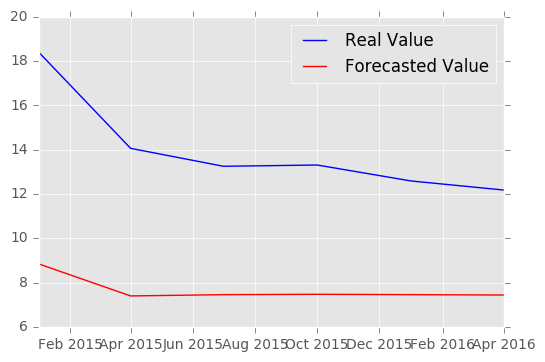

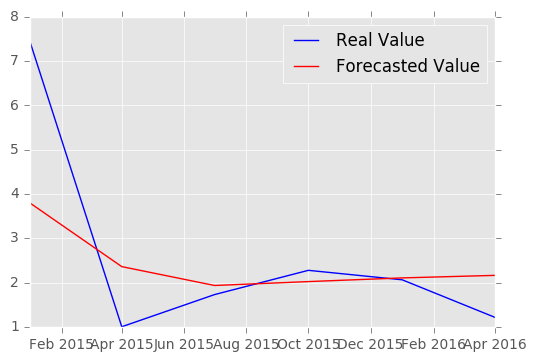

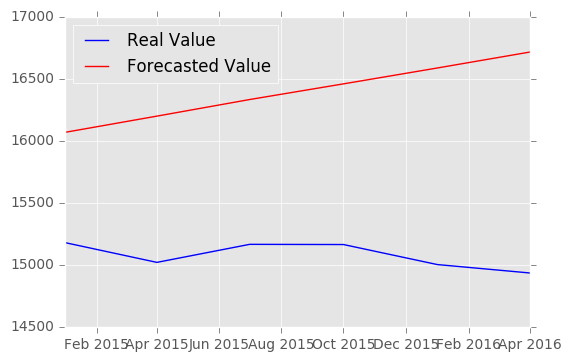

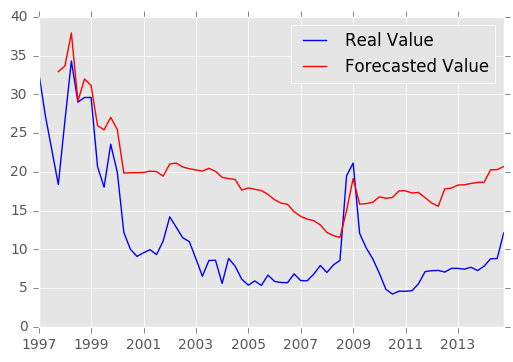

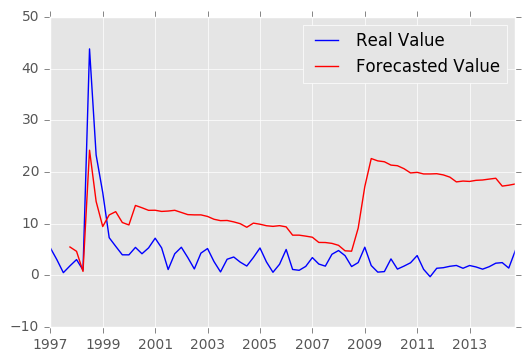

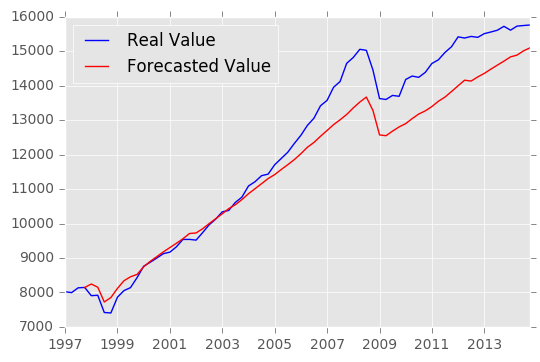

In [255]:
nn_undiff_out = undiff(previous_df=train_real, diff_df=nn_result_as['out'])
nn_undiff_in = undiff(previous_df=train_real.head(1), diff_df=nn_result_as['in'])
print(error(nn_undiff_out['stir'], test_real['stir']))
print(error(nn_undiff_out['infr'], test_real['infr']))
print(error(nn_undiff_out['gdp'], test_real['gdp']))
plot_compar(nn_undiff_out['stir'], test_real['stir'])
plot_compar(nn_undiff_out['infr'], test_real['infr'])
plot_compar(nn_undiff_out['gdp'], test_real['gdp'])
plot_compar(nn_undiff_in['stir'], train_real['stir'])
plot_compar(nn_undiff_in['infr'], train_real['infr'])
plot_compar(nn_undiff_in['gdp'], train_real['gdp'])

На оригинальных данных, а не разницах

In [256]:
df_nn = nn_transform(train_real, n=LAG)
df_nn_s, m, s = scaler(df_nn)
train_nn_x = df_nn_s.iloc[:, 3:].copy()
train_nn_y = df_nn_s.iloc[:, :3].copy()

In [257]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)

Epoch 1/600
0s - loss: 1.5768
Epoch 2/600
0s - loss: 1.1967
Epoch 3/600
0s - loss: 1.0423
Epoch 4/600
0s - loss: 0.9715
Epoch 5/600
0s - loss: 0.9297
Epoch 6/600
0s - loss: 0.8988
Epoch 7/600
0s - loss: 0.8737
Epoch 8/600
0s - loss: 0.8435
Epoch 9/600
0s - loss: 0.8127
Epoch 10/600
0s - loss: 0.7821
Epoch 11/600
0s - loss: 0.7574
Epoch 12/600
0s - loss: 0.7205
Epoch 13/600
0s - loss: 0.6905
Epoch 14/600
0s - loss: 0.6619
Epoch 15/600
0s - loss: 0.6310
Epoch 16/600
0s - loss: 0.6047
Epoch 17/600
0s - loss: 0.5799
Epoch 18/600
0s - loss: 0.5563
Epoch 19/600
0s - loss: 0.5351
Epoch 20/600
0s - loss: 0.5169
Epoch 21/600
0s - loss: 0.5009
Epoch 22/600
0s - loss: 0.4861
Epoch 23/600
0s - loss: 0.4719
Epoch 24/600
0s - loss: 0.4619
Epoch 25/600
0s - loss: 0.4523
Epoch 26/600
0s - loss: 0.4434
Epoch 27/600
0s - loss: 0.4349
Epoch 28/600
0s - loss: 0.4281
Epoch 29/600
0s - loss: 0.4222
Epoch 30/600
0s - loss: 0.4160
Epoch 31/600
0s - loss: 0.4110
Epoch 32/600
0s - loss: 0.4039
Epoch 33/600
0s -

{'mae': 0.50216047612649162, 'mse': 0.37023156433709126, 'rmse': 0.60846656796991838}
{'mae': 1.1942320688226815, 'mse': 2.3789950641740703, 'rmse': 1.5423991260935253}
{'mae': 550.06749010316435, 'mse': 468626.23687455786, 'rmse': 684.56280710724991}


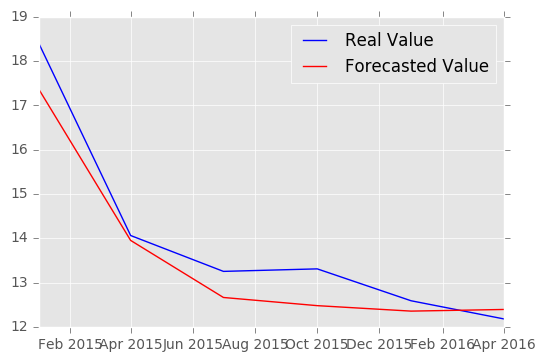

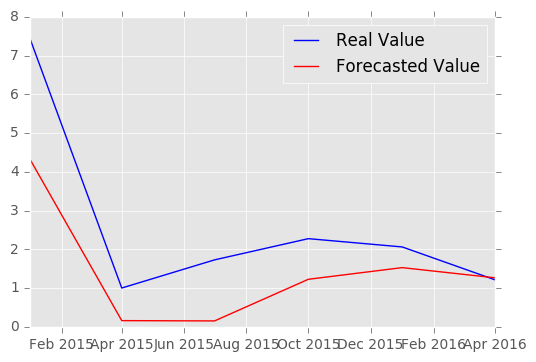

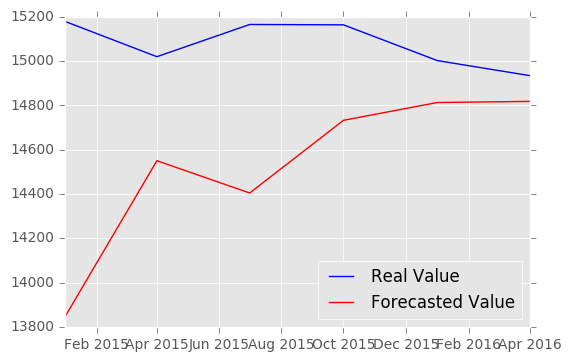

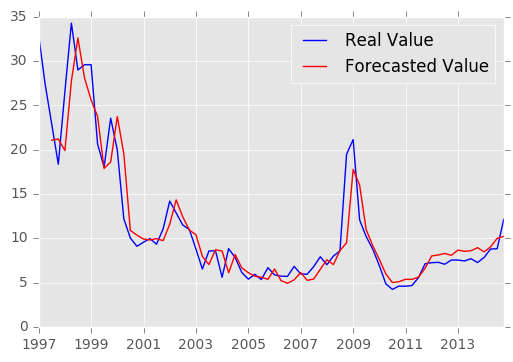

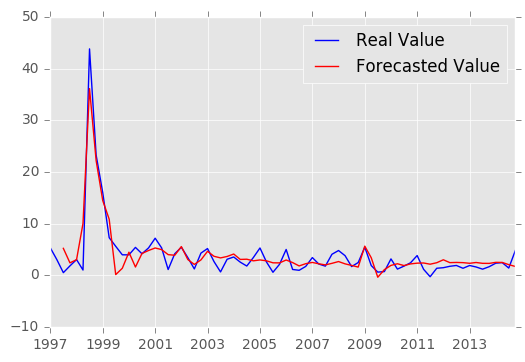

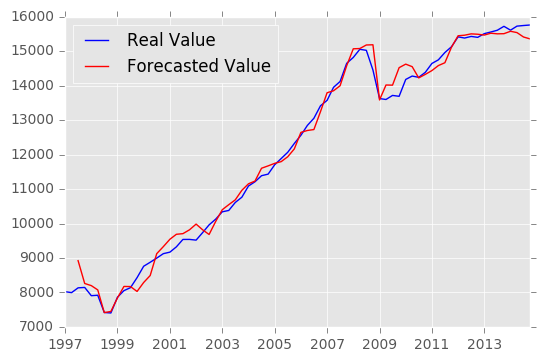

In [258]:
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

Второй запуск (не на разницах)

In [260]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 1.0631
Epoch 2/600
0s - loss: 0.9952
Epoch 3/600
0s - loss: 0.9633
Epoch 4/600
0s - loss: 0.9373
Epoch 5/600
0s - loss: 0.9192
Epoch 6/600
0s - loss: 0.8987
Epoch 7/600
0s - loss: 0.8733
Epoch 8/600
0s - loss: 0.8479
Epoch 9/600
0s - loss: 0.8185
Epoch 10/600
0s - loss: 0.7918
Epoch 11/600
0s - loss: 0.7594
Epoch 12/600
0s - loss: 0.7281
Epoch 13/600
0s - loss: 0.6986
Epoch 14/600
0s - loss: 0.6660
Epoch 15/600
0s - loss: 0.6355
Epoch 16/600
0s - loss: 0.6078
Epoch 17/600
0s - loss: 0.5823
Epoch 18/600
0s - loss: 0.5572
Epoch 19/600
0s - loss: 0.5369
Epoch 20/600
0s - loss: 0.5196
Epoch 21/600
0s - loss: 0.5026
Epoch 22/600
0s - loss: 0.4891
Epoch 23/600
0s - loss: 0.4749
Epoch 24/600
0s - loss: 0.4659
Epoch 25/600
0s - loss: 0.4562
Epoch 26/600
0s - loss: 0.4464
Epoch 27/600
0s - loss: 0.4391
Epoch 28/600
0s - loss: 0.4329
Epoch 29/600
0s - loss: 0.4262
Epoch 30/600
0s - loss: 0.4204
Epoch 31/600
0s - loss: 0.4148
Epoch 32/600
0s - loss: 0.4100
Epoch 33/600
0s -

{'mae': 1.3393355244964884, 'mse': 2.4704935402295054, 'rmse': 1.5717803727714332}
{'mae': 1.3174367592748191, 'mse': 6.2578513879338518, 'rmse': 2.5015697847419434}
{'mae': 551.56705733857837, 'mse': 367975.38200183026, 'rmse': 606.60974440065684}


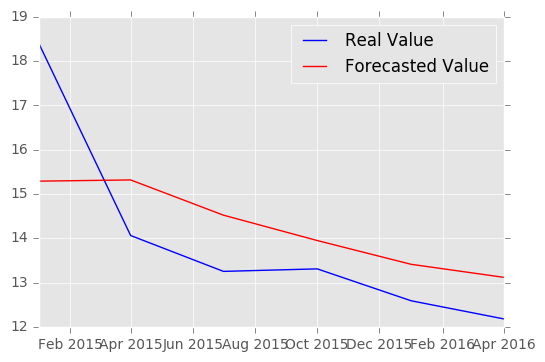

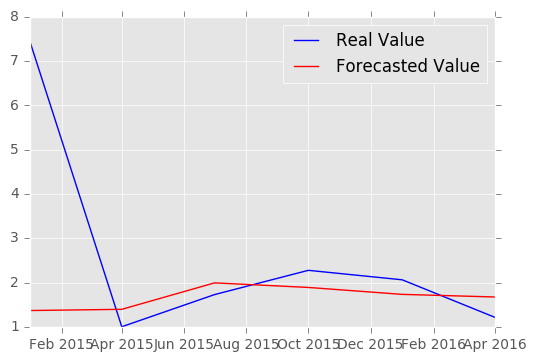

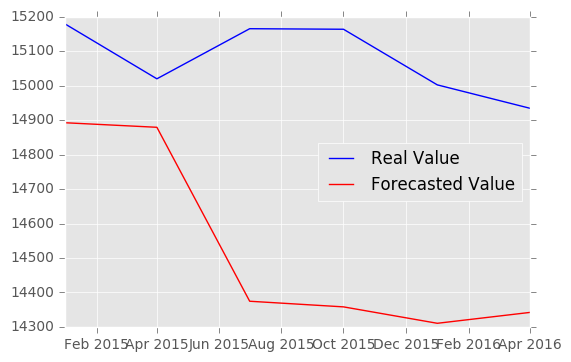

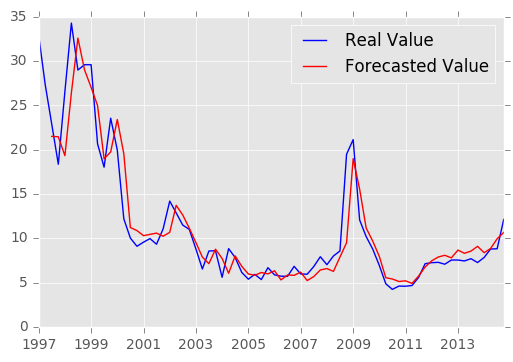

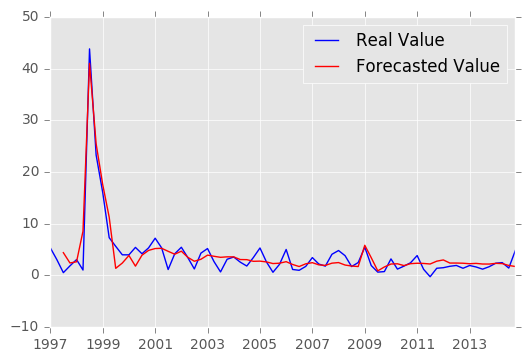

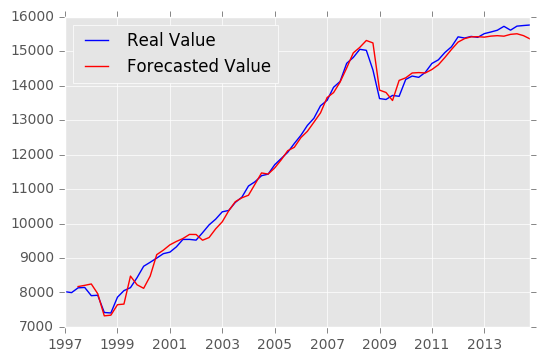

In [261]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

С DropOut

In [263]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
nn_result = nn_model(train_nn_x, train_nn_y, 
                     n_feat=3, lag=LAG, steps=STEPS, model=nn, 
                     years=train_nn_y.index, 
                     epoch=600)
nn_result_as = {'in':scaler_back(nn_result['in'], m, s)[train_real.columns.tolist()], 
                'out':scaler_back(nn_result['out'], m, s)[train_real.columns.tolist()]}

Epoch 1/600
0s - loss: 1.1829
Epoch 2/600
0s - loss: 1.0389
Epoch 3/600
0s - loss: 0.9760
Epoch 4/600
0s - loss: 0.9413
Epoch 5/600
0s - loss: 0.9058
Epoch 6/600
0s - loss: 0.8752
Epoch 7/600
0s - loss: 0.8422
Epoch 8/600
0s - loss: 0.8097
Epoch 9/600
0s - loss: 0.7726
Epoch 10/600
0s - loss: 0.7358
Epoch 11/600
0s - loss: 0.6992
Epoch 12/600
0s - loss: 0.6656
Epoch 13/600
0s - loss: 0.6330
Epoch 14/600
0s - loss: 0.6035
Epoch 15/600
0s - loss: 0.5756
Epoch 16/600
0s - loss: 0.5534
Epoch 17/600
0s - loss: 0.5323
Epoch 18/600
0s - loss: 0.5135
Epoch 19/600
0s - loss: 0.4988
Epoch 20/600
0s - loss: 0.4866
Epoch 21/600
0s - loss: 0.4768
Epoch 22/600
0s - loss: 0.4668
Epoch 23/600
0s - loss: 0.4584
Epoch 24/600
0s - loss: 0.4498
Epoch 25/600
0s - loss: 0.4454
Epoch 26/600
0s - loss: 0.4372
Epoch 27/600
0s - loss: 0.4321
Epoch 28/600
0s - loss: 0.4255
Epoch 29/600
0s - loss: 0.4191
Epoch 30/600
0s - loss: 0.4128
Epoch 31/600
0s - loss: 0.4083
Epoch 32/600
0s - loss: 0.4038
Epoch 33/600
0s -

{'mae': 0.82050195388499214, 'mse': 1.3061287086903439, 'rmse': 1.1428598814773157}
{'mae': 1.2666358489595664, 'mse': 4.0771794826574208, 'rmse': 2.0192026848876319}
{'mae': 368.70676673120397, 'mse': 267798.83596136753, 'rmse': 517.49283662807113}


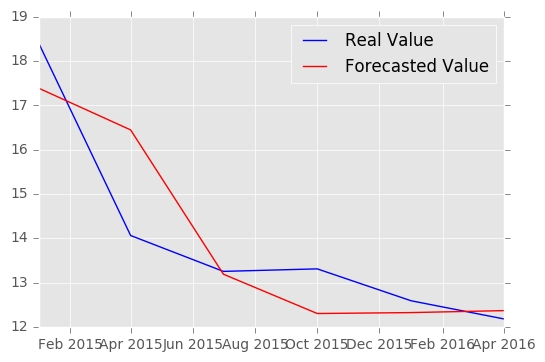

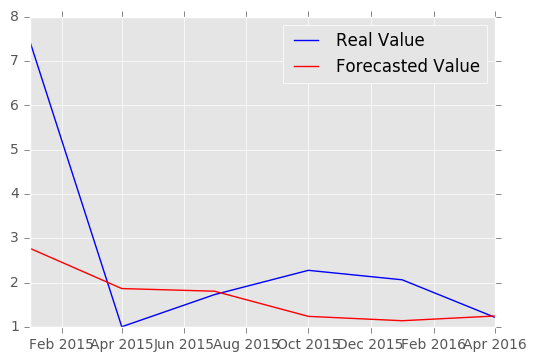

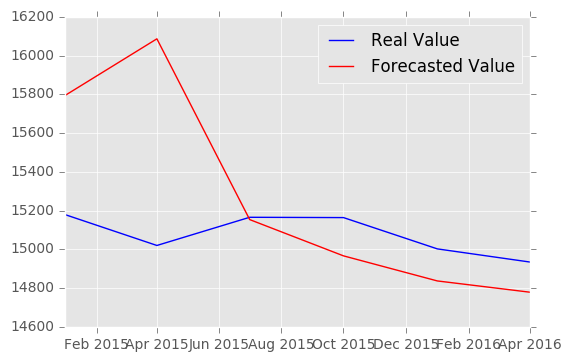

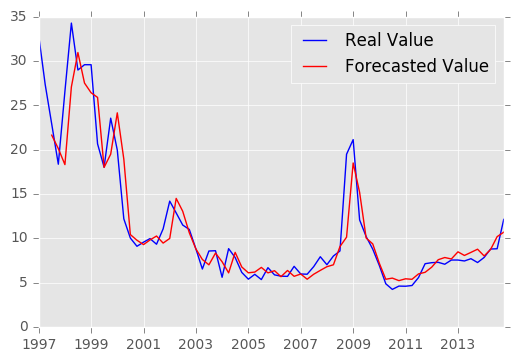

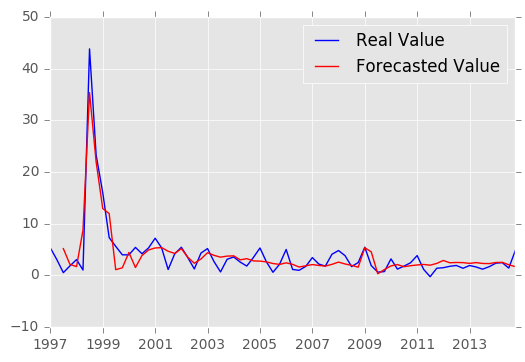

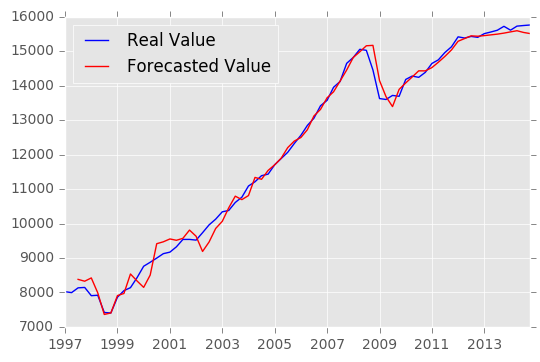

In [264]:
print(error(nn_result_as['out']['stir'], test_real['stir']))
print(error(nn_result_as['out']['infr'], test_real['infr']))
print(error(nn_result_as['out']['gdp'], test_real['gdp']))

plot_compar(nn_result_as['out']['stir'], test_real['stir'])
plot_compar(nn_result_as['out']['infr'], test_real['infr'])
plot_compar(nn_result_as['out']['gdp'], test_real['gdp'])
plot_compar(nn_result_as['in']['stir'], train_real['stir'])
plot_compar(nn_result_as['in']['infr'], train_real['infr'])
plot_compar(nn_result_as['in']['gdp'], train_real['gdp'])

## Hybrid

In [325]:
def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    
    resid_df = pd.DataFrame(fitm.resid)
    resid_df.columns = train.columns
    
    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_result + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns
    
    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3
    
    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

In [326]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)

In [327]:
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.1361
Epoch 2/200
0s - loss: 1.0319
Epoch 3/200
0s - loss: 1.0010
Epoch 4/200
0s - loss: 0.9919
Epoch 5/200
0s - loss: 0.9886
Epoch 6/200
0s - loss: 0.9878
Epoch 7/200
0s - loss: 0.9884
Epoch 8/200
0s - loss: 0.9871
Epoch 9/200
0s - loss: 0.9863
Epoch 10/200
0s - loss: 0.9906
Epoch 11/200
0s - loss: 0.9853
Epoch 12/200
0s - loss: 0.9861
Epoch 13/200
0s - loss: 0.9857
Epoch 14/200
0s - loss: 0.9870
Epoch 15/200
0s - loss: 0.9846
Epoch 16/200
0s - loss: 0.9818
Epoch 17/200
0s - loss: 0.9852
Epoch 18/200
0s - loss: 0.9840
Epoch 19/200
0s - loss: 0.9842
Epoch 20/200
0s - loss: 0.9822
Epoch 21/200
0s - loss: 0.9853
Epoch 22/200
0s - loss: 0.9822
Epoch 23/200
0s - loss: 0.9805
Epoch 24/200
0s - loss: 0.9828
Epoch 25/200
0s - loss: 0.9802
Epoch 26/200
0s - loss: 0.9804
Epoch 27/200
0s - loss: 0.9794
Epoch 28/200
0s - loss: 0.9810
Epoch 29/200
0s - loss: 0.9755
Epoch 30/200
0s - loss: 0.9797
Epoch 31/200
0s - loss: 0.9787
Epoch 32/200
0s - loss: 0.9749
Epoch 33/200
0s -

{'mae': 2.0669888876784435, 'mse': 10.368643408760311, 'rmse': 3.2200377961695281}
{'mae': 2.2872366870777143, 'mse': 11.972662107696697, 'rmse': 3.4601534803671208}
{'mae': 246.9013131008804, 'mse': 109496.9342575984, 'rmse': 330.90320980250164}


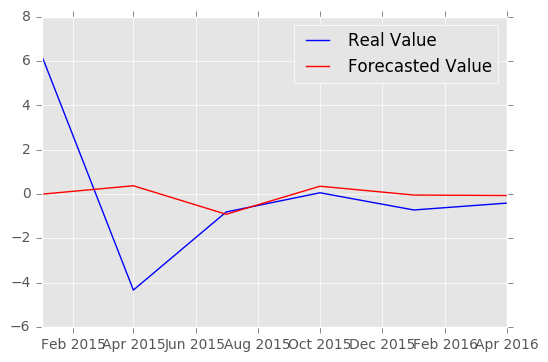

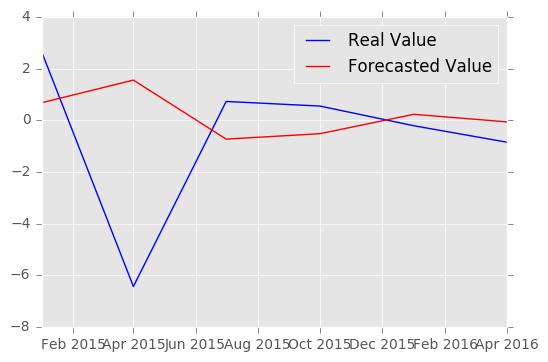

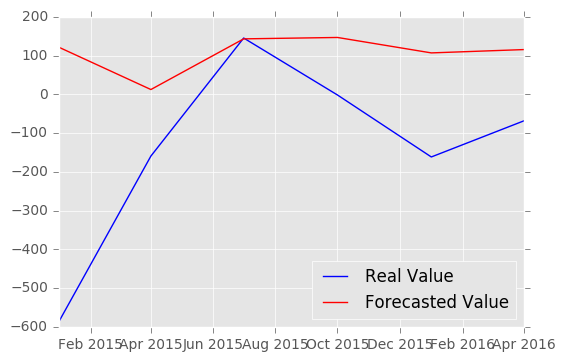

In [328]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'mae': 1.9882122915960958, 'mse': 7.8468241073098213, 'rmse': 2.8012183255344132}
{'mae': 4.1120447883324163, 'mse': 18.433789196385082, 'rmse': 4.2934588849067925}
{'mae': 1042.8598613381691, 'mse': 1157446.342099122, 'rmse': 1075.8468023371738}


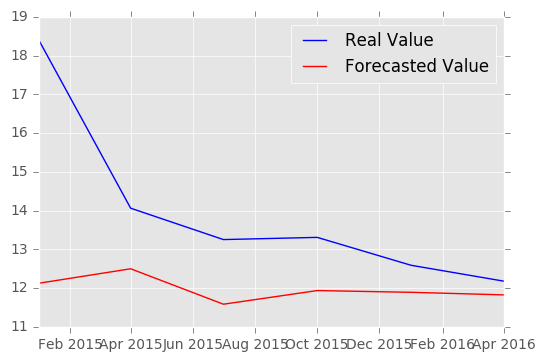

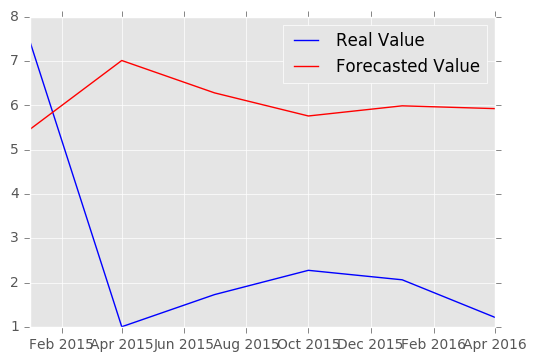

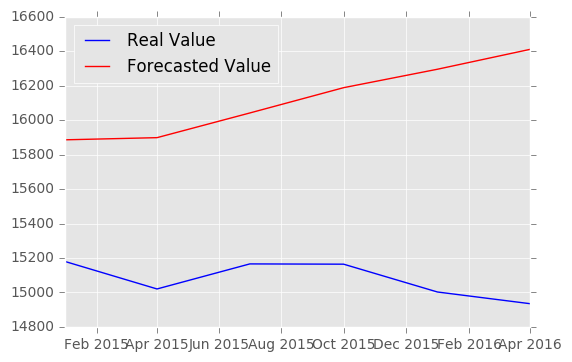

In [329]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

Второй запуск

In [330]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.2370
Epoch 2/200
0s - loss: 1.0818
Epoch 3/200
0s - loss: 1.0253
Epoch 4/200
0s - loss: 1.0074
Epoch 5/200
0s - loss: 0.9965
Epoch 6/200
0s - loss: 0.9930
Epoch 7/200
0s - loss: 0.9917
Epoch 8/200
0s - loss: 0.9905
Epoch 9/200
0s - loss: 0.9918
Epoch 10/200
0s - loss: 0.9884
Epoch 11/200
0s - loss: 0.9875
Epoch 12/200
0s - loss: 0.9887
Epoch 13/200
0s - loss: 0.9896
Epoch 14/200
0s - loss: 0.9877
Epoch 15/200
0s - loss: 0.9875
Epoch 16/200
0s - loss: 0.9854
Epoch 17/200
0s - loss: 0.9853
Epoch 18/200
0s - loss: 0.9870
Epoch 19/200
0s - loss: 0.9857
Epoch 20/200
0s - loss: 0.9835
Epoch 21/200
0s - loss: 0.9866
Epoch 22/200
0s - loss: 0.9845
Epoch 23/200
0s - loss: 0.9867
Epoch 24/200
0s - loss: 0.9821
Epoch 25/200
0s - loss: 0.9859
Epoch 26/200
0s - loss: 0.9830
Epoch 27/200
0s - loss: 0.9853
Epoch 28/200
0s - loss: 0.9804
Epoch 29/200
0s - loss: 0.9825
Epoch 30/200
0s - loss: 0.9817
Epoch 31/200
0s - loss: 0.9817
Epoch 32/200
0s - loss: 0.9792
Epoch 33/200
0s -

{'mae': 1.7746532515731051, 'mse': 6.080494755579636, 'rmse': 2.4658659240882574}
{'mae': 2.8572133329952103, 'mse': 22.557410357977286, 'rmse': 4.7494642179910445}
{'mae': 234.31823610081165, 'mse': 89618.857106468116, 'rmse': 299.3640878703859}


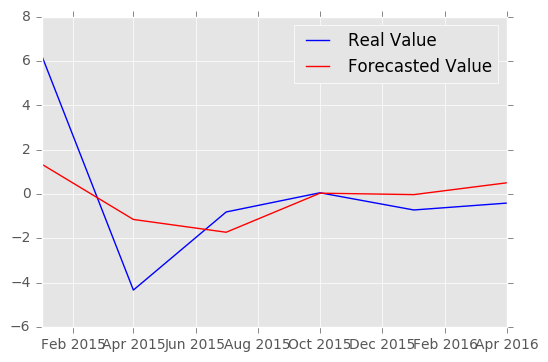

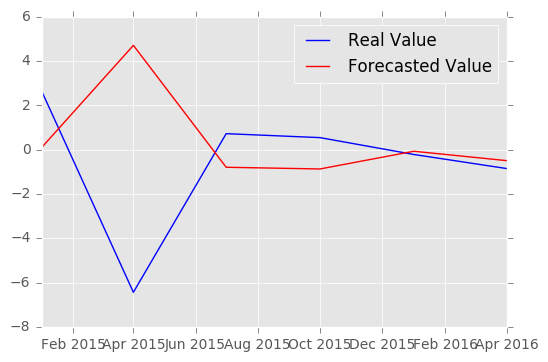

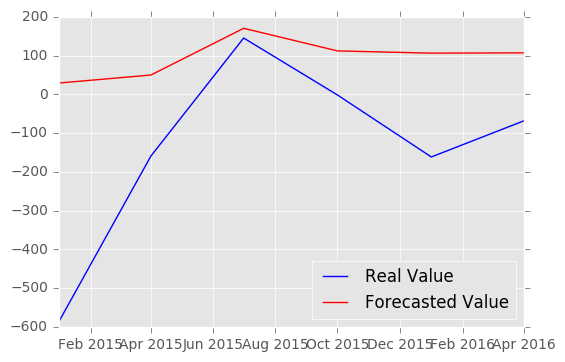

In [331]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'mae': 2.4939818312979312, 'mse': 7.6961774983871543, 'rmse': 2.7741985326193137}
{'mae': 5.9776775804698152, 'mse': 39.055180416526731, 'rmse': 6.2494144058885013}
{'mae': 981.15079464283588, 'mse': 1032570.5294957209, 'rmse': 1016.1547763484266}


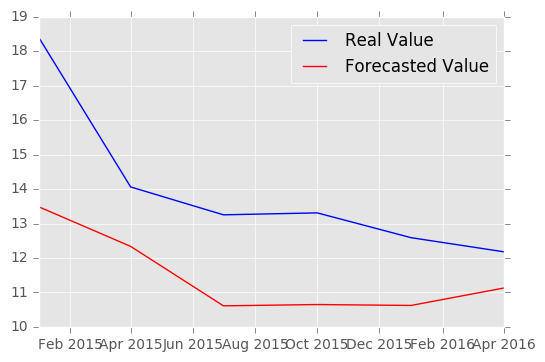

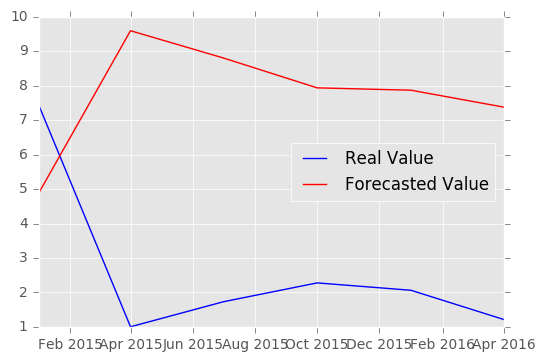

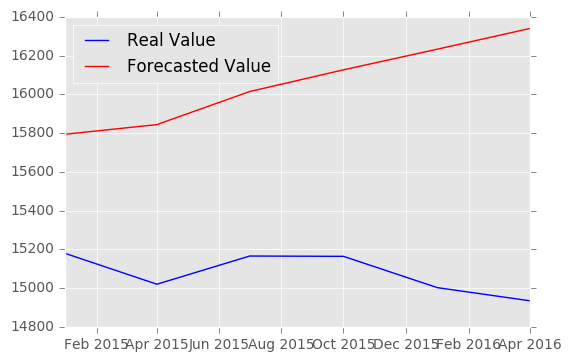

In [332]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

С DropOut

In [333]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result = hybrid_model(train, lags=LAG, steps=STEPS, model_nn=nn, years=True, epoch=200, period='q')

Epoch 1/200
0s - loss: 1.0650
Epoch 2/200
0s - loss: 1.0405
Epoch 3/200
0s - loss: 1.0264
Epoch 4/200
0s - loss: 1.0027
Epoch 5/200
0s - loss: 1.0107
Epoch 6/200
0s - loss: 1.0242
Epoch 7/200
0s - loss: 0.9834
Epoch 8/200
0s - loss: 1.0463
Epoch 9/200
0s - loss: 0.9918
Epoch 10/200
0s - loss: 0.9960
Epoch 11/200
0s - loss: 0.9727
Epoch 12/200
0s - loss: 0.9974
Epoch 13/200
0s - loss: 1.0228
Epoch 14/200
0s - loss: 1.0279
Epoch 15/200
0s - loss: 0.9951
Epoch 16/200
0s - loss: 1.0041
Epoch 17/200
0s - loss: 1.0088
Epoch 18/200
0s - loss: 1.0579
Epoch 19/200
0s - loss: 0.9530
Epoch 20/200
0s - loss: 0.9851
Epoch 21/200
0s - loss: 1.0161
Epoch 22/200
0s - loss: 0.9814
Epoch 23/200
0s - loss: 1.0286
Epoch 24/200
0s - loss: 1.0090
Epoch 25/200
0s - loss: 0.9870
Epoch 26/200
0s - loss: 0.9777
Epoch 27/200
0s - loss: 0.9830
Epoch 28/200
0s - loss: 0.9888
Epoch 29/200
0s - loss: 0.9800
Epoch 30/200
0s - loss: 0.9991
Epoch 31/200
0s - loss: 0.9903
Epoch 32/200
0s - loss: 1.0208
Epoch 33/200
0s -

{'mae': 1.8442719295153049, 'mse': 8.4553871783320655, 'rmse': 2.9078148459508326}
{'mae': 2.1303861361021794, 'mse': 9.0321708506806662, 'rmse': 3.0053570254930886}
{'mae': 237.77868182699606, 'mse': 90404.651521674983, 'rmse': 300.67366283343637}


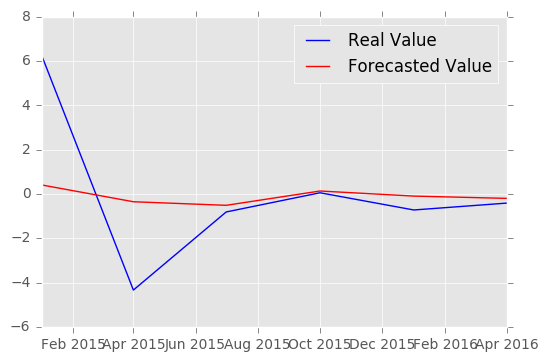

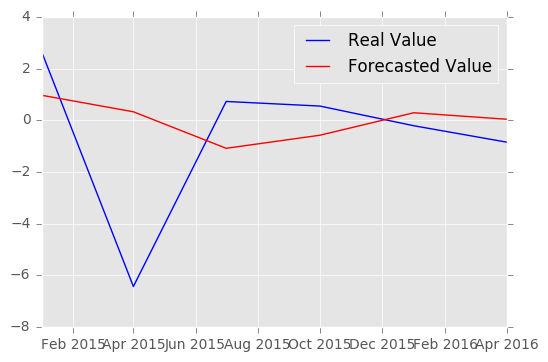

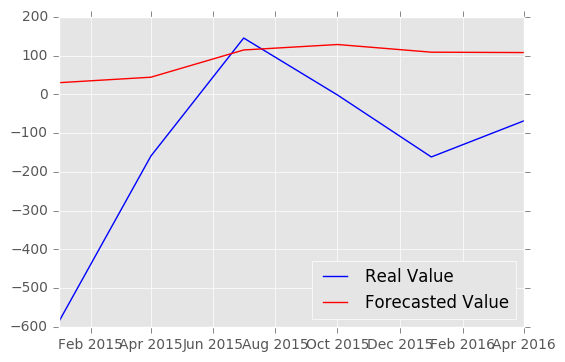

In [334]:
print(error(hybrid_result['stir'], test['stir']))
print(error(hybrid_result['infr'], test['infr']))
print(error(hybrid_result['gdp'], test['gdp']))
plot_compar(hybrid_result['stir'], test['stir'])
plot_compar(hybrid_result['infr'], test['infr'])
plot_compar(hybrid_result['gdp'], test['gdp'])

{'mae': 2.0467943943429368, 'mse': 7.2655442932183698, 'rmse': 2.6954673608148867}
{'mae': 3.0536246294996006, 'mse': 10.530872817578439, 'rmse': 3.2451306318203033}
{'mae': 949.28451518727559, 'mse': 965379.21530147677, 'rmse': 982.53713176728172}


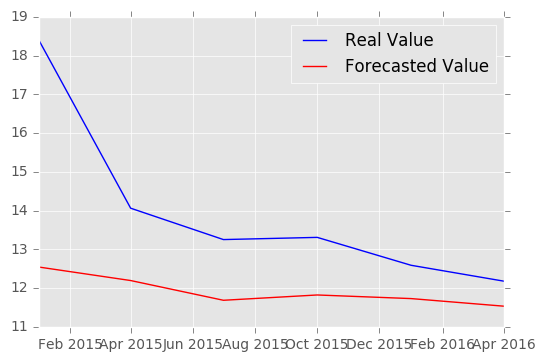

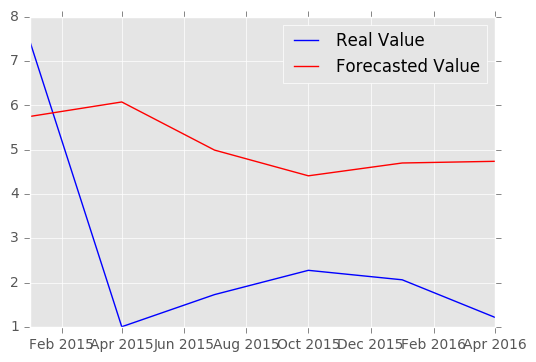

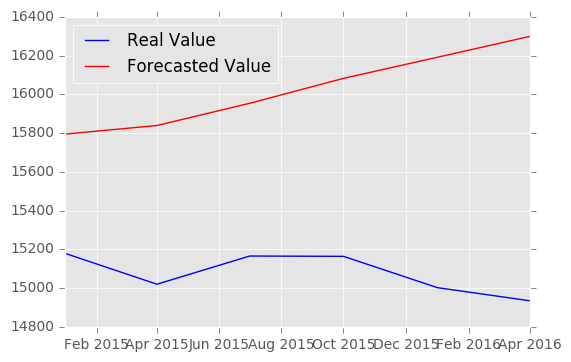

In [335]:
hybrid_undiff_out = undiff(previous_df=train_real, diff_df=hybrid_result)
print(error(hybrid_undiff_out['stir'], test_real['stir']))
print(error(hybrid_undiff_out['infr'], test_real['infr']))
print(error(hybrid_undiff_out['gdp'], test_real['gdp']))
plot_compar(hybrid_undiff_out['stir'], test_real['stir'])
plot_compar(hybrid_undiff_out['infr'], test_real['infr'])
plot_compar(hybrid_undiff_out['gdp'], test_real['gdp'])

### Hybrid_full

In [336]:
#def hybrid_model(train, lags, steps, model_nn, years=True, epoch=100, period='m'):
# lags = LAG
# steps=STEPS
# model_nn=nn
# years=True
# epoch=200
# period='q'

def hybrid_model_undiff(train, train_real, lags, steps, model_nn, years=True, epoch=100, period='m'):
    n_feat = len(train.columns)
    model = VAR(np.array(train))
    fitm = model.fit(maxlags=lags)
    var_result = fitm.forecast(y=np.array(train), steps=steps)
    var_in = undiff(previous_df=train_real.head(1), diff_df=pd.DataFrame(fitm.fittedvalues))
    var_out = undiff(previous_df=train_real, diff_df=pd.DataFrame(var_result))
    resid_df = pd.DataFrame(train_real.iloc[lags+1:, :].as_matrix() - var_in.as_matrix())
    resid_df.columns = train.columns

    df_nn = nn_transform(resid_df, n=lags)
    ###
    df_nn_s, m, s = scaler(df_nn)
    ###
    train_nn_x = df_nn_s.iloc[:, n_feat:].copy()
    train_nn_y = df_nn_s.iloc[:, :n_feat].copy()
    model_nn.fit(np.array(train_nn_x), np.array(train_nn_y),
           nb_epoch=epoch, 
           verbose=2,
           batch_size=1)
    nn_result = nn_predict(model_nn, resid_df, lags=lags, steps=steps)
    ###
    nn_result_as = scaler_back(nn_result, m, s)[train.columns.tolist()]
    ###
    hybrid_result = pd.DataFrame(var_out.as_matrix() + nn_result_as.as_matrix())
    hybrid_result.columns = train.columns

    b=1
    s=1
    p=steps
    if period=='q':
        p = steps*3
        s=3
        b=3

    if years == True:
        ind = [datetime.strptime(str(train.tail(1).index.tolist()[0])[:7], '%Y-%m') + relativedelta(months=i) \
               for i in range(b, p+1, s)]
        hybrid_result.index = ind
    return hybrid_result

Первый запуск

In [340]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.1698
Epoch 2/500
0s - loss: 1.0334
Epoch 3/500
0s - loss: 0.9703
Epoch 4/500
0s - loss: 0.9280
Epoch 5/500
0s - loss: 0.8978
Epoch 6/500
0s - loss: 0.8680
Epoch 7/500
0s - loss: 0.8397
Epoch 8/500
0s - loss: 0.8140
Epoch 9/500
0s - loss: 0.7828
Epoch 10/500
0s - loss: 0.7568
Epoch 11/500
0s - loss: 0.7229
Epoch 12/500
0s - loss: 0.6904
Epoch 13/500
0s - loss: 0.6604
Epoch 14/500
0s - loss: 0.6280
Epoch 15/500
0s - loss: 0.5974
Epoch 16/500
0s - loss: 0.5687
Epoch 17/500
0s - loss: 0.5416
Epoch 18/500
0s - loss: 0.5147
Epoch 19/500
0s - loss: 0.4906
Epoch 20/500
0s - loss: 0.4679
Epoch 21/500
0s - loss: 0.4488
Epoch 22/500
0s - loss: 0.4291
Epoch 23/500
0s - loss: 0.4111
Epoch 24/500
0s - loss: 0.3959
Epoch 25/500
0s - loss: 0.3822
Epoch 26/500
0s - loss: 0.3675
Epoch 27/500
0s - loss: 0.3538
Epoch 28/500
0s - loss: 0.3420
Epoch 29/500
0s - loss: 0.3337
Epoch 30/500
0s - loss: 0.3233
Epoch 31/500
0s - loss: 0.3137
Epoch 32/500
0s - loss: 0.3063
Epoch 33/500
0s -

{'mae': 20.585270717169397, 'mse': 430.72860943481902, 'rmse': 20.754002251007371}
{'mae': 7.3029586113133149, 'mse': 96.034154615487466, 'rmse': 9.7997017615582287}
{'mae': 1128.0749356436393, 'mse': 1378648.7658371665, 'rmse': 1174.1587481414795}


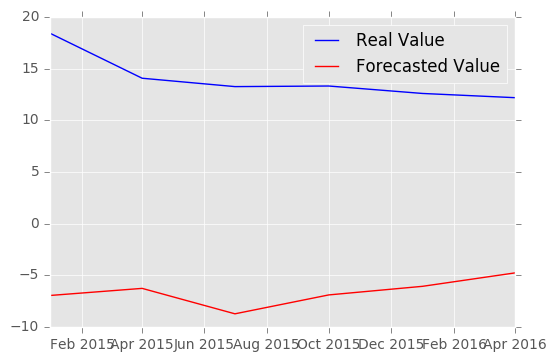

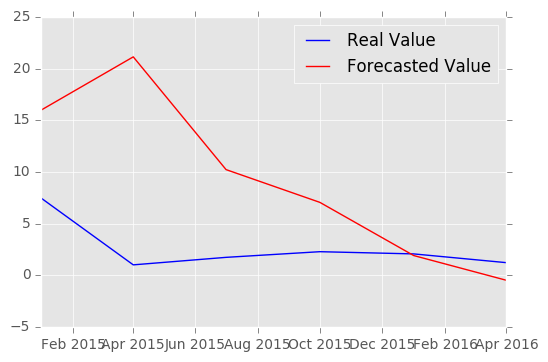

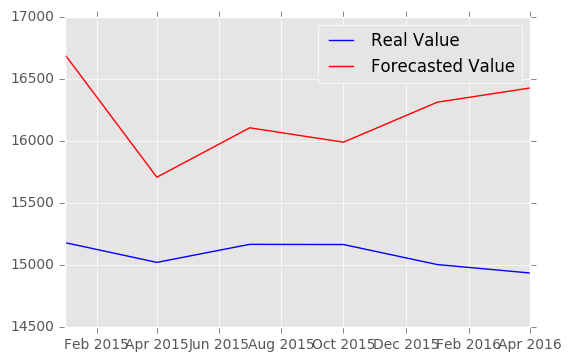

In [341]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])

Второй запуск

In [342]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.1491
Epoch 2/500
0s - loss: 1.0020
Epoch 3/500
0s - loss: 0.9264
Epoch 4/500
0s - loss: 0.8829
Epoch 5/500
0s - loss: 0.8406
Epoch 6/500
0s - loss: 0.8044
Epoch 7/500
0s - loss: 0.7703
Epoch 8/500
0s - loss: 0.7353
Epoch 9/500
0s - loss: 0.7031
Epoch 10/500
0s - loss: 0.6675
Epoch 11/500
0s - loss: 0.6362
Epoch 12/500
0s - loss: 0.5998
Epoch 13/500
0s - loss: 0.5664
Epoch 14/500
0s - loss: 0.5359
Epoch 15/500
0s - loss: 0.5074
Epoch 16/500
0s - loss: 0.4793
Epoch 17/500
0s - loss: 0.4561
Epoch 18/500
0s - loss: 0.4312
Epoch 19/500
0s - loss: 0.4091
Epoch 20/500
0s - loss: 0.3901
Epoch 21/500
0s - loss: 0.3731
Epoch 22/500
0s - loss: 0.3591
Epoch 23/500
0s - loss: 0.3468
Epoch 24/500
0s - loss: 0.3337
Epoch 25/500
0s - loss: 0.3248
Epoch 26/500
0s - loss: 0.3168
Epoch 27/500
0s - loss: 0.3078
Epoch 28/500
0s - loss: 0.3023
Epoch 29/500
0s - loss: 0.2970
Epoch 30/500
0s - loss: 0.2915
Epoch 31/500
0s - loss: 0.2894
Epoch 32/500
0s - loss: 0.2853
Epoch 33/500
0s -

{'mae': 16.532076887199249, 'mse': 279.40158365872344, 'rmse': 16.71530985829229}
{'mae': 5.2144075648492612, 'mse': 36.287028471868048, 'rmse': 6.0238715517404628}
{'mae': 1241.9452174201012, 'mse': 1582964.7423591788, 'rmse': 1258.1592674853127}


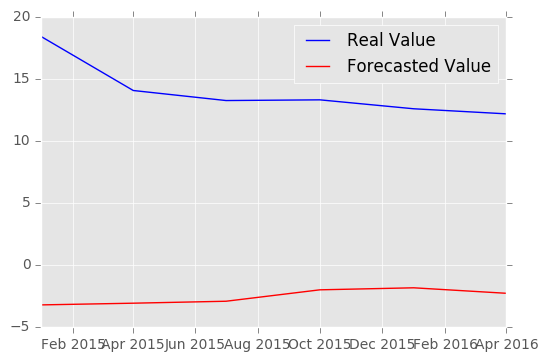

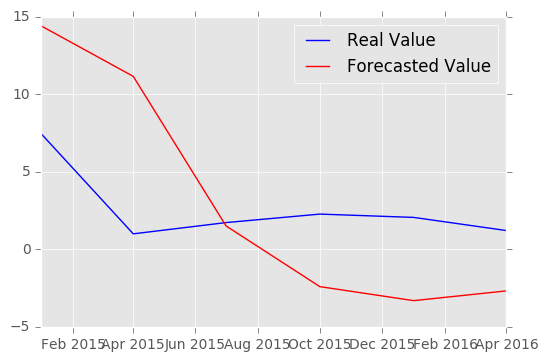

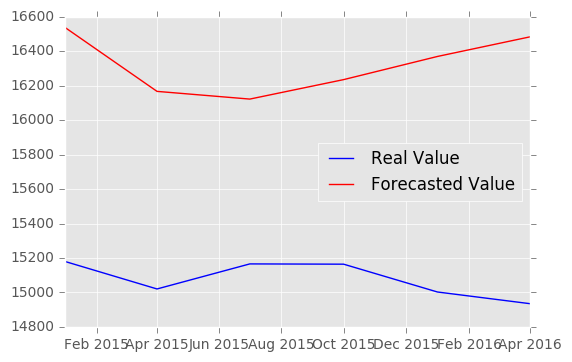

In [343]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])

С DropOut

In [348]:
def assemble_model(n_feat, lag):
    model = Sequential()
    # Layers
    model.add(Dense(10, input_dim=n_feat*lag, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(10, input_dim=10, activation='sigmoid'))
    model.add(Dense(n_feat, input_dim=10))
    # Compilation
    model.compile(loss='mean_squared_error', optimizer='adam')
    return(model)

nn = assemble_model(3, LAG)
hybrid_result_undiff = hybrid_model_undiff(train, train_real, lags=LAG, steps=STEPS, 
                                    model_nn=nn, years=True, epoch=500, period='q')

Epoch 1/500
0s - loss: 1.1282
Epoch 2/500
0s - loss: 1.0487
Epoch 3/500
0s - loss: 1.0069
Epoch 4/500
0s - loss: 1.0302
Epoch 5/500
0s - loss: 1.0049
Epoch 6/500
0s - loss: 1.0200
Epoch 7/500
0s - loss: 0.9825
Epoch 8/500
0s - loss: 1.0103
Epoch 9/500
0s - loss: 0.9592
Epoch 10/500
0s - loss: 0.9691
Epoch 11/500
0s - loss: 0.9787
Epoch 12/500
0s - loss: 0.9345
Epoch 13/500
0s - loss: 0.9013
Epoch 14/500
0s - loss: 0.8931
Epoch 15/500
0s - loss: 0.9084
Epoch 16/500
0s - loss: 0.9209
Epoch 17/500
0s - loss: 0.8987
Epoch 18/500
0s - loss: 0.8938
Epoch 19/500
0s - loss: 0.8492
Epoch 20/500
0s - loss: 0.8509
Epoch 21/500
0s - loss: 0.8576
Epoch 22/500
0s - loss: 0.8447
Epoch 23/500
0s - loss: 0.7920
Epoch 24/500
0s - loss: 0.7903
Epoch 25/500
0s - loss: 0.8659
Epoch 26/500
0s - loss: 0.8308
Epoch 27/500
0s - loss: 0.8069
Epoch 28/500
0s - loss: 0.8126
Epoch 29/500
0s - loss: 0.8095
Epoch 30/500
0s - loss: 0.8073
Epoch 31/500
0s - loss: 0.8091
Epoch 32/500
0s - loss: 0.7569
Epoch 33/500
0s -

{'mae': 22.39897087822165, 'mse': 502.99174629915575, 'rmse': 22.427477484085358}
{'mae': 3.1954803343899614, 'mse': 10.700252465875046, 'rmse': 3.2711240370666235}
{'mae': 1473.8585160778048, 'mse': 2241307.1984235691, 'rmse': 1497.0995953588288}


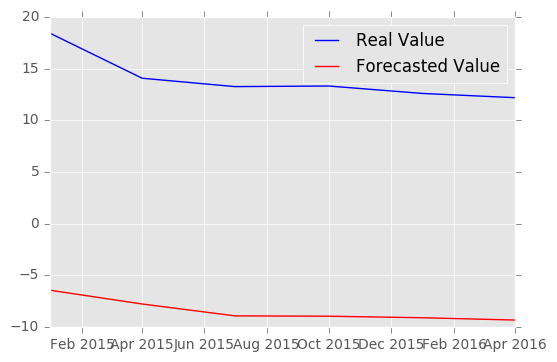

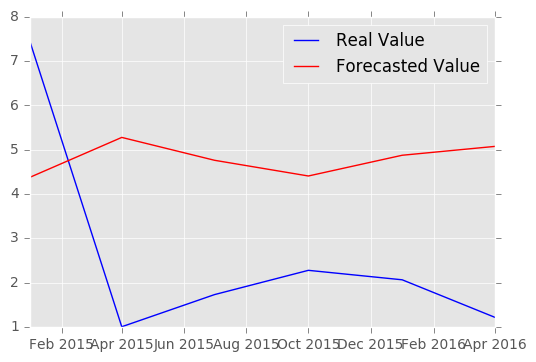

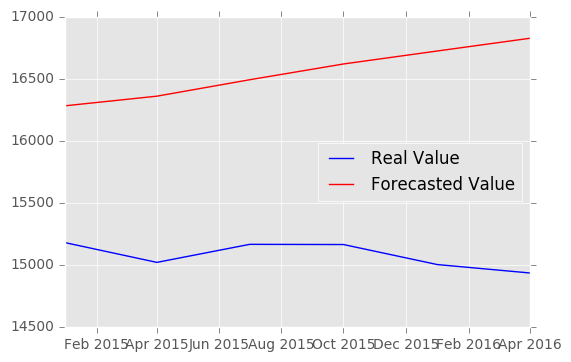

In [349]:
print(error(hybrid_result_undiff['stir'], test_real['stir']))
print(error(hybrid_result_undiff['infr'], test_real['infr']))
print(error(hybrid_result_undiff['gdp'], test_real['gdp']))
plot_compar(hybrid_result_undiff['stir'], test_real['stir'])
plot_compar(hybrid_result_undiff['infr'], test_real['infr'])
plot_compar(hybrid_result_undiff['gdp'], test_real['gdp'])